In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from numpy.linalg import inv, pinv
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, f1_score
from IPython.display import display, Markdown
'''
Format data in array 
'''
vertebral_data = pd.read_csv("column_2C.dat", sep=" ", header=None)
column_names = ["pelvic incidence", "pelvic tilt", "lumbar lordosis angle", "sacral slope", "pelvic radius", "grade of spondylolisthesis", "class"]
vertebral_data.columns = column_names
for i, row in vertebral_data.iterrows():
    if "AB" == vertebral_data.at[i,'class']:
        vertebral_data.at[i,'class'] = 1 
    elif "NO" == vertebral_data.at[i,'class']: 
        vertebral_data.at[i,'class'] = 0
#vertebral_data

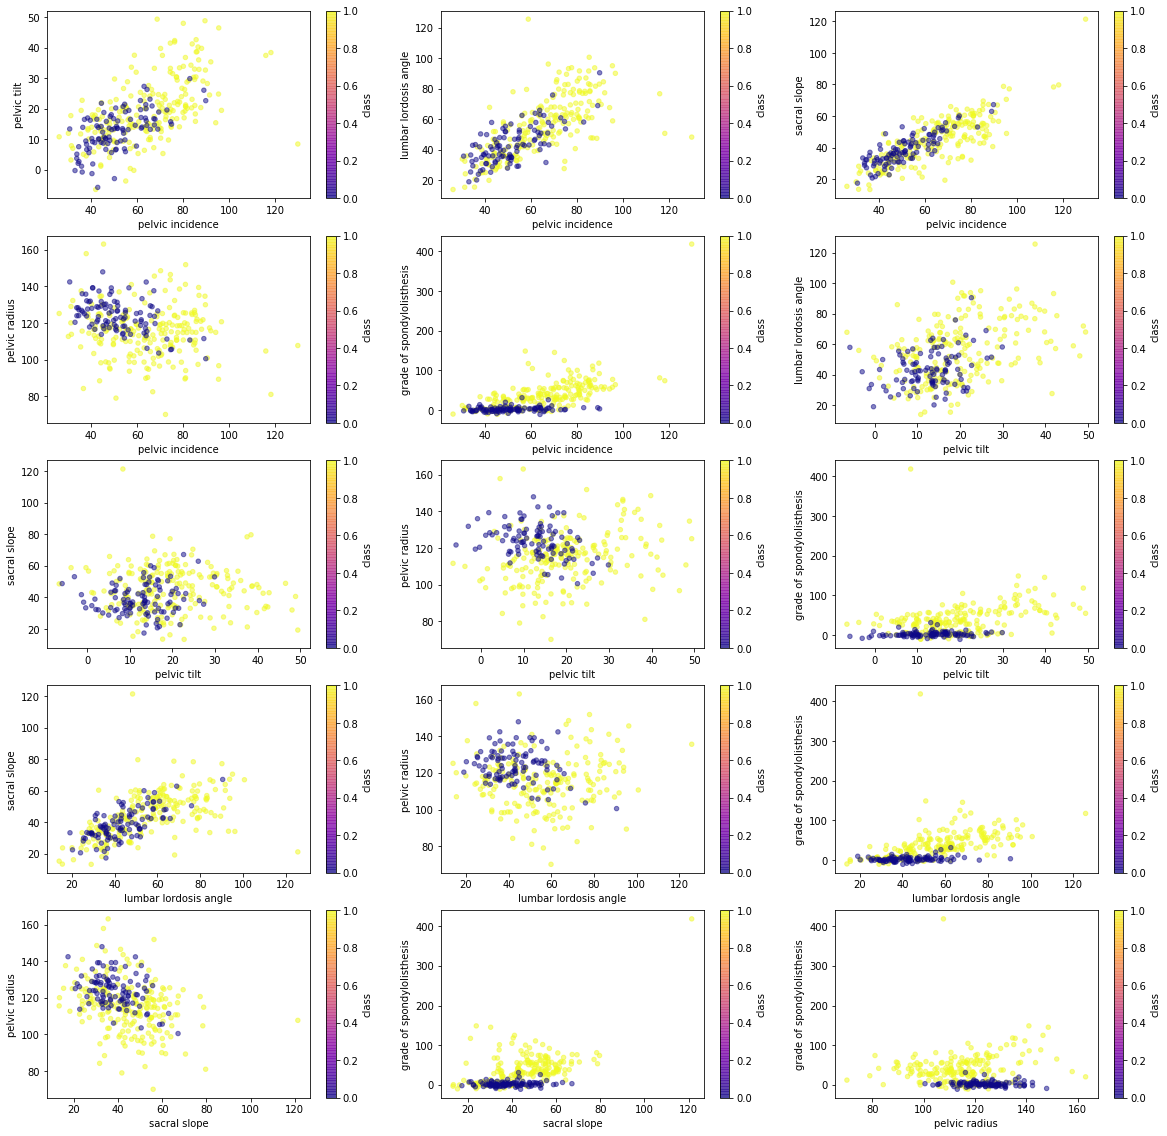

In [2]:
'''
b(i)
subplot with panda: https://stackoverflow.com/questions/22483588/how-can-i-plot-separate-pandas-dataframes-as-subplots
'''
fig, axes = plt.subplots(nrows=5, ncols=3)
index = 0
for i in range(5):
    for j in range(i+1, 6): 
        x_label = column_names[i]
        y_label = column_names[j]
        vertebral_data.plot(kind="scatter", x=x_label, y=y_label, c=column_names[6], alpha = 0.5, 
                            colormap='plasma', ax = axes[int(index/3), index%3], figsize=(20,20))
        plt.xlabel(x_label) 
        plt.ylabel(y_label)
        index += 1

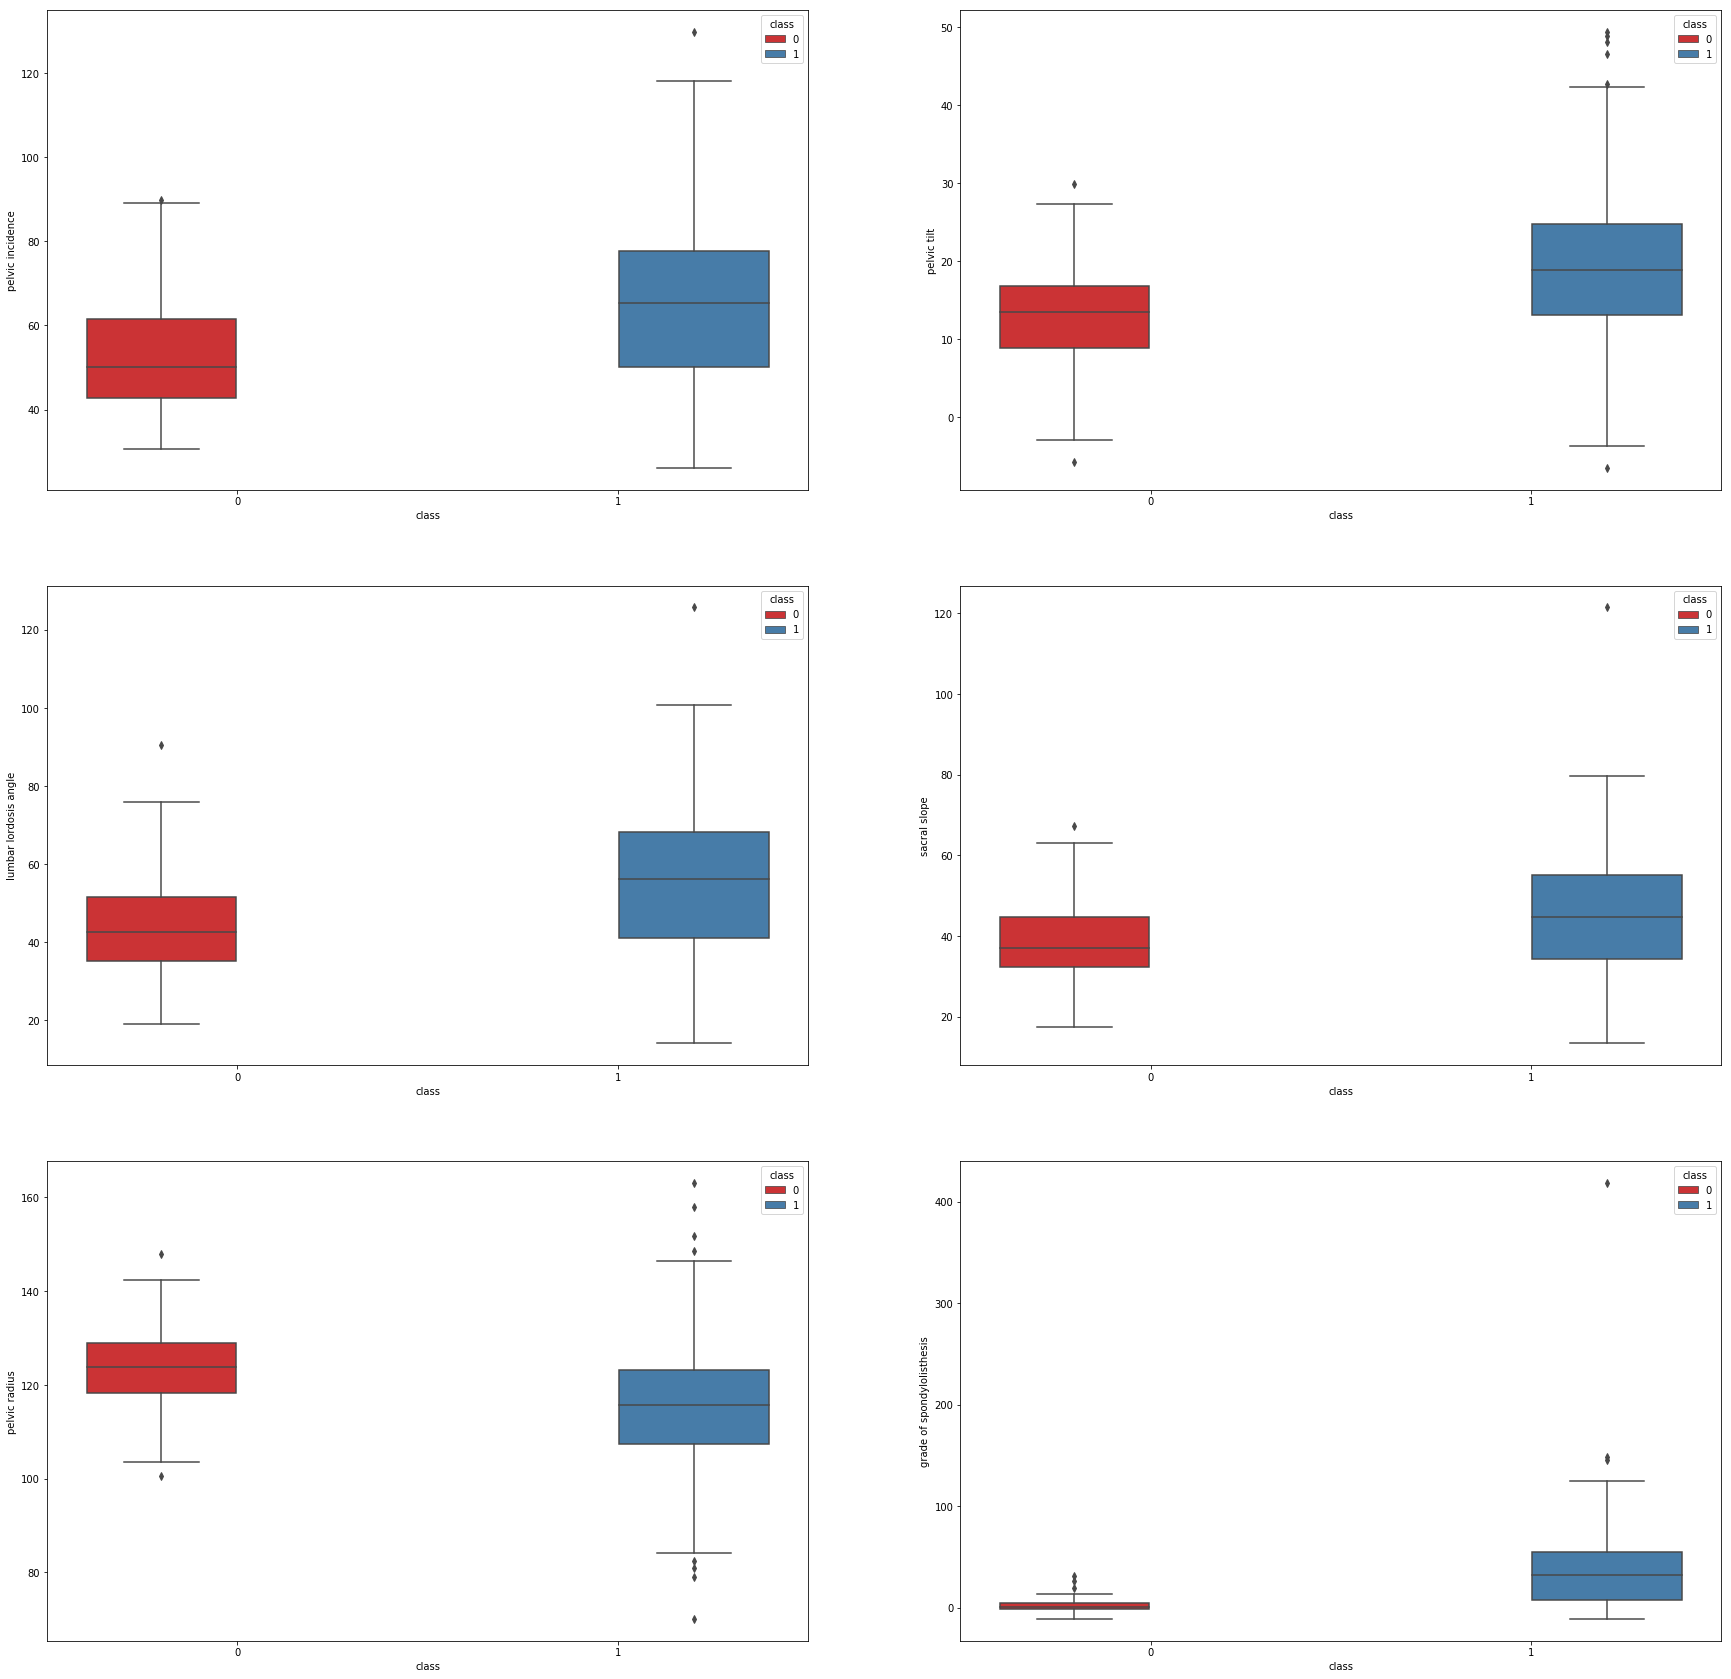

In [3]:
'''
b(ii)
sns differentiate class with color where panda doesn't
https://seaborn.pydata.org/generated/seaborn.boxplot.html
https://pandas.pydata.org/pandas-docs/version/0.23.3/generated/pandas.DataFrame.boxplot.html#pandas.DataFrame.boxplot
TODO: when generate graphs in for loop graphs overlaps with each other. 
'''
#vertebral_data.boxplot(column=column_names[0], by=column_names[6])
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(30,30))
for i in range(6):
    sns.boxplot(x=column_names[6], y=column_names[i], hue="class", data=vertebral_data, 
                palette="Set1", ax=axes[int(i/2), i%2])

In [4]:
'''
b(iii)
Data selection tutorial: https://medium.com/dunder-data/selecting-subsets-of-data-in-pandas-6fcd0170be9c
'''
abnormal_data = vertebral_data[vertebral_data["class"]==1]
normal_data = vertebral_data[vertebral_data["class"]==0]
abnormal_data_train = abnormal_data.loc[0:139] #140 rows
abnormal_data_test = abnormal_data.loc[140:] #70 rows 
normal_data.index = range(100)
normal_data_train = normal_data.loc[0:69] # 70 rows 
normal_data_test = normal_data.loc[70:] # 30 rows 

train_frames = [abnormal_data_train, normal_data_train]
train_data = pd.concat(train_frames)
train_data.index = range(210)

test_frames = [abnormal_data_test, normal_data_test]
test_data = pd.concat(test_frames)
test_data.index = range(100)

# convert to numpy arrays of features and targets 
np_train_features =  train_data.iloc[:,0:6].values
np_train_targets = train_data.iloc[:,6:7].values.astype('int32').ravel()

np_test_features =  test_data.iloc[:,0:6].values
np_test_targets = test_data.iloc[:,6:7].values.astype('int32').ravel()


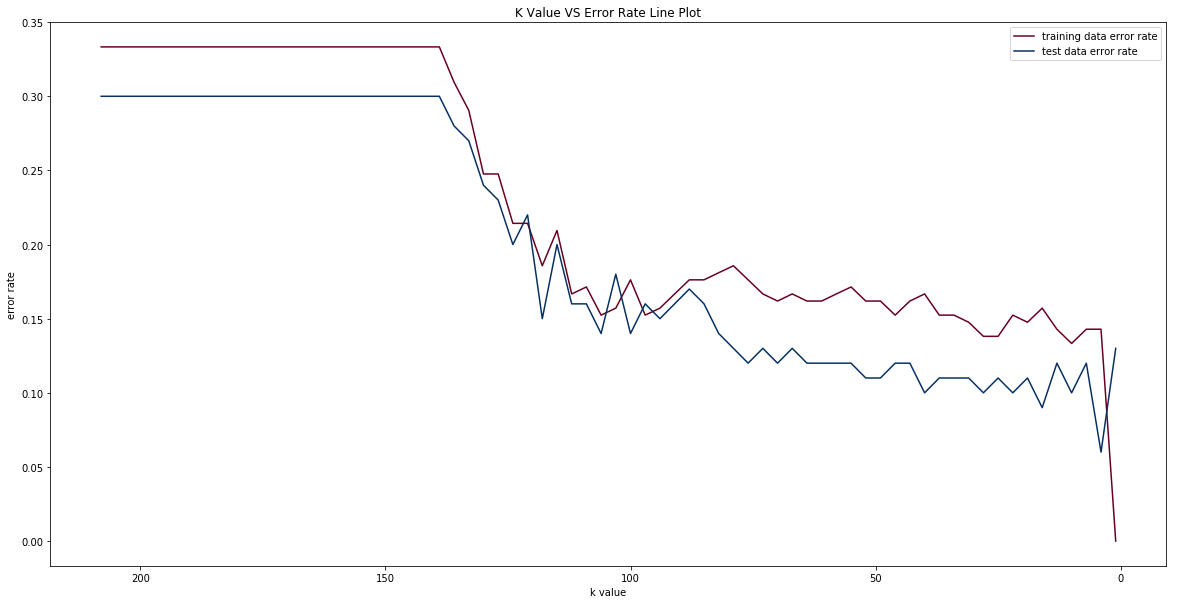

k* with value: 4 has the lowest test error rate: 0.06


confusion matrix is:

[[25  5]
 [ 1 69]]


true positive rate: 0.9857 true negative rate: 0.8333

precision is: 0.9324

f score is: 0.9583

In [5]:
'''
c(i), (ii)
Scikit learn tutorial: https://www.youtube.com/watch?v=IsXXlYVBt1M 

{features_data, target_data} (1)separate objects and numberic, (2)numpy arrays 
X = feature (2D matrix)
y = target 

scikit distance metrics: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html
scikit knn doc: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
'''
trainData_errorRates = []
testData_errorRates = []
k_values = []
for k in range(208, -2, -3):
    neigh = KNeighborsClassifier(n_neighbors=k, metric="euclidean") 
    neigh.fit(np_train_features, np_train_targets) 
    trainData_errorRates.append( round ((1 - neigh.score(np_train_features, np_train_targets)), 4))
    testData_errorRates.append( round ((1 - neigh.score(np_test_features, np_test_targets)), 4)) 
    k_values.append(k)

error_data = []
error_data.append(k_values)
error_data.append(trainData_errorRates)
error_data.append(testData_errorRates)
error_data = [*zip(*error_data)] # matrix transpose 
pd_error_data = pd.DataFrame.from_records(error_data, columns=["k value", "training data error rate", "test data error rate"])
pd_error_data.plot(x="k value", y=["training data error rate", "test data error rate"], colormap='RdBu', figsize=(20,10))
#reverse X order 
plt.gca().invert_xaxis()
plt.xlabel("k value") 
plt.ylabel("error rate")
plt.title("K Value VS Error Rate Line Plot")
plt.show()


min_test_error = min(testData_errorRates)
min_error_index = testData_errorRates.index(min_test_error)
k_star = k_values[min_error_index] 
display(Markdown ("k* with value: " +  str(k_star) + " has the lowest test error rate: " + str(min_test_error)))

neigh = KNeighborsClassifier(n_neighbors=k_star, metric="euclidean") 
neigh.fit(np_train_features, np_train_targets) 
prediction_array = neigh.predict(np_test_features)
display(Markdown ("\nconfusion matrix is:"))
print (confusion_matrix(np_test_targets, prediction_array))
tn, fp, fn, tp = confusion_matrix(np_test_targets, prediction_array).ravel()
f_score = f1_score(np_test_targets, prediction_array, average="binary")
display(Markdown ("true positive rate: " +  str(round((tp / (tp + fn)), 4))+ " true negative rate: " + str(round( (tn/ (tn + fp)), 4))))
display(Markdown ("precision is: " + str(round((tp / (tp + fp)), 4))))
display(Markdown ("f score is: " + str( round(f_score, 4))))


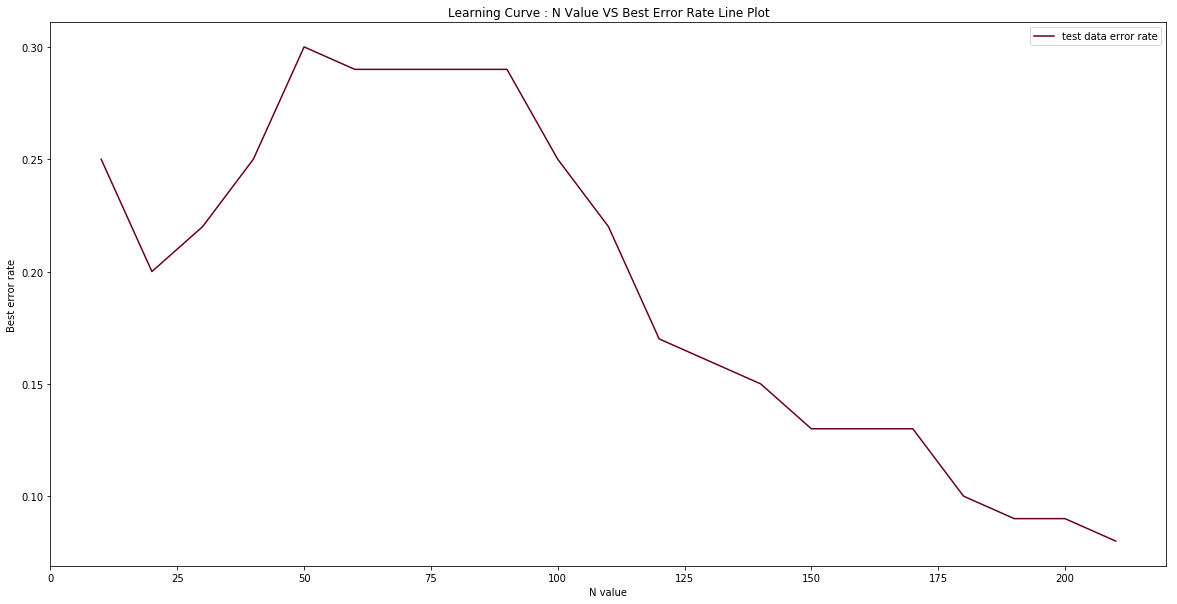

In [10]:
'''
c(iii)
'''
best_test_error_rates = []
best_k = []
list_of_N = []
for N in range (10, 220, 10):
    number_of_normal = int(N/3)
    number_of_abnormal = N - int(N/3)
    temp_NO_train =  normal_data_train.loc[0:number_of_normal-1]
    temp_AB_train =  abnormal_data_train.loc[0:number_of_abnormal-1]
    temp_train_frames = [temp_AB_train, temp_NO_train]
    temp_train_data = pd.concat(temp_train_frames)
    temp_train_data.index = range(number_of_normal + number_of_abnormal)

    # convert to numpy arrays of features and targets 
    temp_np_train_features =  temp_train_data.iloc[:,0:6].values
    temp_np_train_targets = temp_train_data.iloc[:,6:7].values.astype('int32').ravel()
    temp_best_test_err_rate = 1 
    temp_k_star = 0; 
    for k in range(1, N, 5):
        temp_neigh = KNeighborsClassifier(n_neighbors=k, metric="euclidean") 
        temp_neigh.fit(temp_np_train_features, temp_np_train_targets) 
        temp_error_rate = 1 - temp_neigh.score(np_test_features, np_test_targets)
        if temp_error_rate < temp_best_test_err_rate: 
            temp_best_test_err_rate = temp_error_rate 
            temp_k_star = k 
        
    best_test_error_rates.append((round(temp_best_test_err_rate,4)))
    best_k.append(temp_k_star)
    list_of_N.append(N)   
#print(best_test_error_rates, best_k)
#construc graph data and display graph
learning_curve_data = []
learning_curve_data.append(list_of_N)
learning_curve_data.append(best_test_error_rates)

learning_curve_data = [*zip(*learning_curve_data)] # matrix transpose 
pd_learning_curve_data = pd.DataFrame.from_records(learning_curve_data, columns=["N value", "test data error rate"])
pd_learning_curve_data.plot(x="N value", y=["test data error rate"], colormap='RdBu', figsize=(20,10))
plt.xlabel("N value") 
plt.ylabel("Best error rate")
plt.title("Learning Curve : N Value VS Best Error Rate Line Plot")
plt.show()

A. Manhattan: [Minkowski p = 1] Min test error rate is: 0.11 when k is: 6

B. Minkowski [Minkowski k = 6] Min test error rate is: 0.06 when log(p) is: 0.6, best p is: 3.9810717055349722

C. Chebyshev: [Minkowski p = inf] Min test error rate is: 0.08 when k is: 16

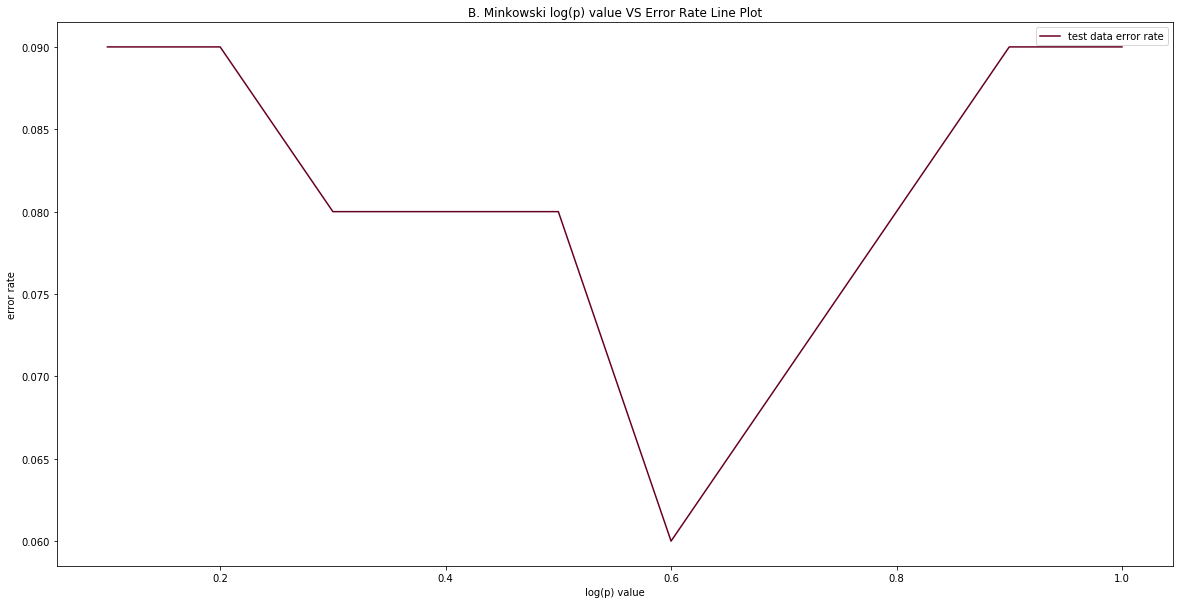

In [11]:
'''
d(i)A
'''
#select k_star when p = 1
min_testData_errorRates_Manhattan = 1 
k_star_Minkowski = 0
for k in range(1, 201, 5):
    neigh = KNeighborsClassifier(n_neighbors=k, metric="minkowski", p=1) 
    neigh.fit(np_train_features, np_train_targets)
    temp_testData_errorRates_Minkowski = round ((1 - neigh.score(np_test_features, np_test_targets)), 4)
    if temp_testData_errorRates_Minkowski < min_testData_errorRates_Manhattan:
        min_testData_errorRates_Manhattan = temp_testData_errorRates_Minkowski
        k_star_Minkowski = k 
display(Markdown ("A. Manhattan: [Minkowski p = 1] Min test error rate is: "+ 
                  str(min_testData_errorRates_Manhattan)+ " when k is: " + str(k_star_Minkowski)))

'''
d(i)B
'''
#run all p s.t. log(p) : {0.1-1.0}
min_testData_errorRates_Minkowski = 1 
p_star_Minkowski = 1 
log_p_list = []
testData_errorRates_Minkowski = []
for x in range(1, 11, 1):
    factor = x/10
    log_p_list.append(factor)
    temp_p = pow(10, factor)
    neigh = KNeighborsClassifier(n_neighbors=k_star_Minkowski, metric="minkowski", p=temp_p) 
    neigh.fit(np_train_features, np_train_targets)
    temp_testData_errorRates_Minkowski = round ((1 - neigh.score(np_test_features, np_test_targets)), 4)
    testData_errorRates_Minkowski.append(temp_testData_errorRates_Minkowski)
    if temp_testData_errorRates_Minkowski < min_testData_errorRates_Minkowski:
        min_testData_errorRates_Minkowski = temp_testData_errorRates_Minkowski
        p_star_Minkowski = temp_p 
display(Markdown  ("B. Minkowski [Minkowski k = " + str(k_star_Minkowski) + "] Min test error rate is: " + 
                  str(min_testData_errorRates_Minkowski) + " when log(p) is: " + str(math.log10(p_star_Minkowski)) +
                   ", best p is: " + str(p_star_Minkowski)))    

'''
d(i)C
'''
min_testData_errorRates_Chebyshev = 1 
k_star_Chebyshev = 0
for k in range(1, 201, 5):
    neigh = KNeighborsClassifier(n_neighbors=k, metric="minkowski", p=math.inf) 
    neigh.fit(np_train_features, np_train_targets)
    temp_testData_errorRates_Chebyshev = round ((1 - neigh.score(np_test_features, np_test_targets)), 4)
    if temp_testData_errorRates_Chebyshev < min_testData_errorRates_Chebyshev:
        min_testData_errorRates_Chebyshev = temp_testData_errorRates_Chebyshev
        k_star_Chebyshev = k 
display(Markdown ("C. Chebyshev: [Minkowski p = inf] Min test error rate is: "+ 
                  str(min_testData_errorRates_Chebyshev)+ " when k is: " + str(k_star_Chebyshev)))


#construc graph data and display graph
minkowski_data = []
minkowski_data.append(log_p_list)
minkowski_data.append(testData_errorRates_Minkowski)

minkowski_data = [*zip(*minkowski_data)] # matrix transpose 
pd_minkowski_data = pd.DataFrame.from_records(minkowski_data, columns=["log(p) value", "test data error rate"])
pd_minkowski_data.plot(x="log(p) value", y=["test data error rate"], colormap='RdBu', figsize=(20,10))
plt.xlabel("log(p) value") 
plt.ylabel("error rate")
plt.title("B. Minkowski log(p) value VS Error Rate Line Plot")
plt.show()


In [8]:
'''
d(ii)
Mahalanobis Distance
'''
np_train_features_transpose =  np_train_features.transpose()
np_train_features_cov_M = np.cov(np_train_features_transpose)
#np_train_features_cov_M_inv = inv(np_train_features_cov_M)
#pesudo-inverse covariance matrix, rcond default 1e-15, lowest error rate achived at rcond=1e-1
np_train_features_cov_M_pinv = pinv(np_train_features_cov_M, rcond=1e-1)
#print(np_train_features_cov_M_pinv)
min_testData_errorRates_Mahalanobis = 1 
k_star_Mahalanobis = 0
for k in range(1, 201, 5):
    neigh = KNeighborsClassifier(n_neighbors=k, metric="mahalanobis", metric_params={"VI": np_train_features_cov_M_pinv}) 
    neigh.fit(np_train_features, np_train_targets)
    temp_testData_errorRates_Mahalanobis = round ((1 - neigh.score(np_test_features, np_test_targets)), 4)
    if temp_testData_errorRates_Mahalanobis < min_testData_errorRates_Mahalanobis:
        min_testData_errorRates_Mahalanobis = temp_testData_errorRates_Mahalanobis 
        k_star_Mahalanobis = k
        
display(Markdown ("D. Mahalanobis: Min test error rate is: "+ 
                  str(min_testData_errorRates_Mahalanobis)+ " when k is: " + str(k_star_Mahalanobis)))



D. Mahalanobis: Min test error rate is: 0.07 when k is: 6

In [9]:
'''
e
weighted decision
'''
# [euclidean, manhattan, chebyshev]
best_test_errors = [1, 1, 1] 
for k in range(1, 201, 5): 
    neigh = KNeighborsClassifier(n_neighbors=k, metric="euclidean", weights="distance")
    neigh.fit(np_train_features, np_train_targets)
    temp_testData_errorRates_Euclidean_weighted = round ((1 - neigh.score(np_test_features, np_test_targets)), 4)
    #print(temp_testData_errorRates_Euclidean_weighted)
    if best_test_errors[0] > temp_testData_errorRates_Euclidean_weighted: 
        best_test_errors[0] = temp_testData_errorRates_Euclidean_weighted
    neigh = KNeighborsClassifier(n_neighbors=k, metric="manhattan", weights="distance")
    neigh.fit(np_train_features, np_train_targets)
    temp_testData_errorRates_Manhattan_weighted = round ((1 - neigh.score(np_test_features, np_test_targets)), 4)
    #print(temp_testData_errorRates_Manhattan_weighted)
    if best_test_errors[1] > temp_testData_errorRates_Manhattan_weighted: 
        best_test_errors[1] = temp_testData_errorRates_Manhattan_weighted
    neigh = KNeighborsClassifier(n_neighbors=k, metric="chebyshev", weights="distance")
    neigh.fit(np_train_features, np_train_targets)
    temp_testData_errorRates_Chebyshev_weighted = round ((1 - neigh.score(np_test_features, np_test_targets)), 4)
    #print(temp_testData_errorRates_Chebyshev_weighted)
    if best_test_errors[2] > temp_testData_errorRates_Chebyshev_weighted: 
        best_test_errors[2] = temp_testData_errorRates_Chebyshev_weighted

display(Markdown("The best test error for weighted Euclidean distance is :" + str(best_test_errors[0])))
display(Markdown("The best test error for weighted Manhattan distance is :" + str(best_test_errors[1])))
display(Markdown("The best test error for weighted Chebyshev distance is :" + str(best_test_errors[2])))

The best test error for weighted Euclidean distance is :0.1

The best test error for weighted Manhattan distance is :0.1

The best test error for weighted Chebyshev distance is :0.11